In [1]:
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os

from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnpå
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries

from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import flatten_list

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif

from desc.utils import cross, dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import FourierCurrentPotentialField
#from desc.magnetic_fields._current_potential import run_regcoil

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray

from desc.fns_simp import (plot_figure,
                           plot_figure2,
                           plot_xy,
                           surf_int,
                           _compute_magnetic_field_from_Current)

from find_dips import (iso_coords_interp,
                      bn_res,
                      B_dips,
                        B_sticks,
                      K_dips)

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64

Using device: NVIDIA A100 80GB PCIe (id=0), with 80.00 GB available memory

In [3]:
# Plasma surfaces
eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq_QH = desc.io.load(eqname_QH)[4]

eq = eq_QH  
###
surf_winding = load("iso_coords/surf.h5")

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

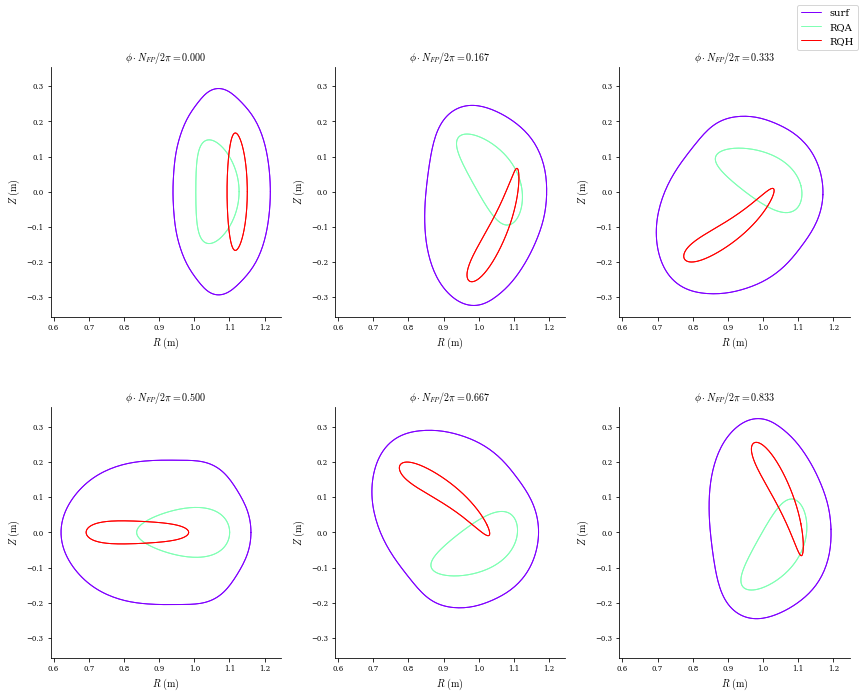

In [4]:
# Plot both surfaces
plot_comparison([surf_winding,eq_QA,eq_QH],labels=["surf","RQA","RQH"],theta=0,rho=np.array(1.0))

In [5]:
# Evaluate Green's function for flat tori
sgrid = LinearGrid(M = 100, N = 140, NFP = surf_winding.NFP)
sdata = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s"], grid = sgrid)
name = 'iso_coords/'
sdata = iso_coords_interp(name, sdata, sgrid, surf_winding)

G = np.load("iso_coords/G.npy")
K_sec = G * cross(sdata["n_rho"], sdata["e^u_s"])
K_sv = surf_winding.compute(["K"],grid = sgrid)["K"]

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

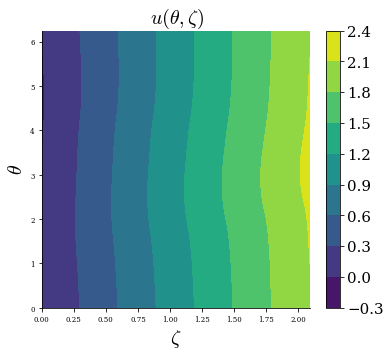

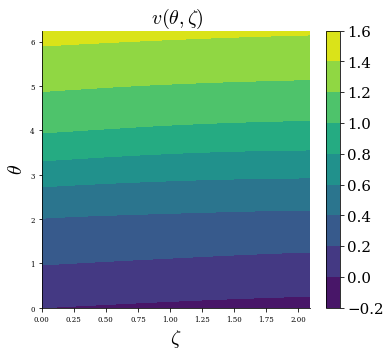

In [6]:
# Confirm that variables have the same shape
plot_figure2(sdata["u_iso"],sgrid,''r' $ u(\theta,\zeta)$ ')
plot_figure2(sdata["v_iso"],sgrid,''r' $ v(\theta,\zeta)$ ')
#plot_figure2(sdata["lambda_iso"],sgrid,''r' $ \lambda $ ')

In [7]:
eps = 1e-2
dt = eps
dz = eps
d0 = eps/3

In [8]:
grid_M = 50
grid_N = 50

In [9]:
egrid = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
edata = eq.compute(["n_rho","B"], grid = egrid)

#B_s = edata["B"]
B_sec = _compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid, basis = "rpz" )
B_s = _compute_magnetic_field_from_Current( sgrid, K_sv, surf_winding, eq, egrid, basis = "rpz" )
#B_s = _compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid, basis = "rpz" )
rhs = jnp.concatenate((B_s[:,0],B_s[:,1],B_s[:,2]))
#- dot( edata["n_rho"],  B_sec )

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

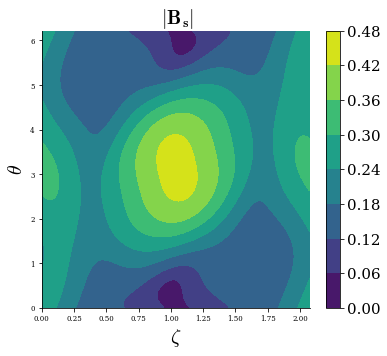

In [10]:
plot_figure2( dot(B_s,B_s) ** (1/2), egrid,''r' $ | \mathbf{B_{s}} |$ ')

In [11]:
N = 20 # Terms toa pproximate the infinite series

# Numer of dipoles
#sMv = np.asarray([5,10,15,20,])
sMv = np.asarray([25])
sNv = np.asarray([55])
#sNv = sMv

b_chi = []
Bn_chi = []
max_I = []

In [12]:
grid_M2 = grid_M #40
grid_N2 = grid_N #40

egrid2 = LinearGrid(M = grid_M2, N = grid_N2, NFP = eq.NFP)
edata2 = eq.compute(["n_rho"], grid = egrid2)

B_sec2 = np.load('iso_coords/B_sec_'+str(grid_M2)+'x'+str(grid_N2)+'.npy')
#_compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid2, basis = "rpz" )
B_s2 = _compute_magnetic_field_from_Current( sgrid, K_sv, surf_winding, eq, egrid2, basis = "rpz" )
#B_s2 = edata2["B"]

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

In [13]:
alpha_v = [#1e-20,1e-19,
           #1e-20,
           1e-10,
           #1e-15,1e-14,
           #1e-13,1e-12,
          ]

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

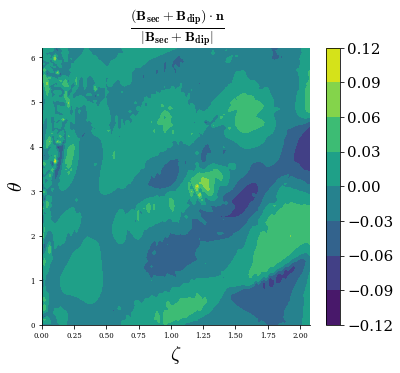

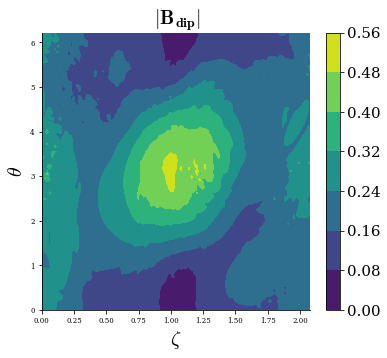

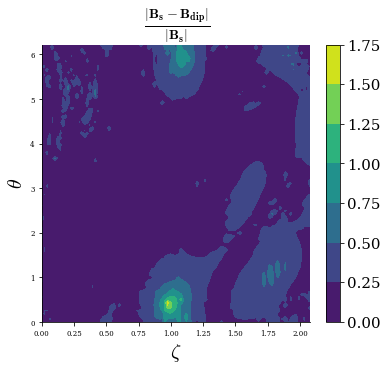

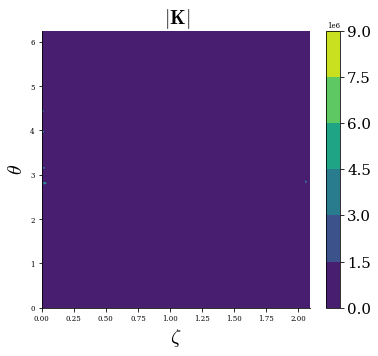

In [14]:
for i in range(0,len(sMv)):

    p_M = sMv[i]
    p_N = sNv[i]
    
    x = jnp.ones( ( p_M * 2 + 1 ) * ( p_N * 2 + 1 ) * 2 + 0 )
    
    fun_wrapped1 = lambda x: bn_res(p_M, p_N, # Dipole pairs in toroidal direction 
                                    sdata, sgrid, surf_winding, #winding_surf,
                                    x, 
                                    dt,dz, N, d0,
                                    eq, egrid)
    
    A = Derivative(fun_wrapped1, deriv_mode="looped").compute(x)
    
    alpha = 1e-11
    #A_inv, _ = svd_inv_null( A.T @ A + alpha * jnp.eye( A.shape[1] ) )
    
    # Find the regularized solution of dipoles
    #soln = A_inv @ ( rhs @ A)
    soln = jnp.linalg.pinv(A.T @ A + alpha * jnp.eye( A.shape[1] )) @ ( rhs @ A)
    #soln = jnp.linalg.pinv(A) @ rhs
    #soln = jnp.linalg.pinv(A + alpha * jnp.eye( A.shape[0],A.shape[1] )) @ rhs
    
    #B_d2 = ( B_dips(p_M, p_N,
    #             sdata, sgrid, surf_winding,
    #             soln,
    #             dt,dz, N, d0,
    #             eq, egrid2) 
    #        + B_sticks(p_M, p_N,
    #             sdata, sgrid, surf_winding,
    #             soln,
    #             dt,dz,
    #             eq, egrid2)
    #        )
    
    test = A@soln
    tsize = edata2['n_rho'].shape[0]
    B_d2 = jnp.column_stack((test[0:tsize],test[tsize:tsize*2],test[tsize*2:tsize*3]))
    
    K_d = K_dips(p_M, p_N,
                 sdata, sgrid, surf_winding,
                 soln,
                 dt,dz, N, d0)
    
    
    #B0 = B_d2 - B_s2
    B0 = B_d2 - B_s2
    B_total = B_d2 + B_sec2
    Bn_total = dot(edata2["n_rho"],B_total)
    K0 = K_d
    
    #res = A @ soln - rhs
    
    #plot_figure2( res, egrid, ''r' $ \mathbf{B \cdot n}$ ' )
    plot_figure2( Bn_total * dot(B_total,B_total)**(1/2), egrid2,
                 ''r' $ \frac{ (\mathbf{B_{sec} + B_{dip}}) \cdot \mathbf{n} }{| \mathbf{B_{sec} + B_{dip}} | }$ ' )
    
    plot_figure2( dot(B_d2,B_d2)**(1/2), egrid2, ''r' $ | \mathbf{B_{dip}} | $ ' )
    
    plot_figure2( dot(B0,B0)**(1/2) * dot(B_s2,B_s2)**(-1/2), 
                 egrid2, 
                 ''r' $ \frac{| \mathbf{B_s - B_{dip}}  |}{|\mathbf{B_s}|} $ ' )
    
    plot_figure2( dot(K0,K0)**(1/2), sgrid, ''r' $ | \mathbf{K} | $ ' )
    
    error = surf_int( dot(B0,B0) ** 2, edata2, egrid2 )
    b_chi.append(error)
    Bn_chi.append( max(abs(Bn_total * dot(B_total,B_total)**(-1/2)))) 
    #G_chi.append(soln[-1])
    max_I.append(max(abs(soln[0 : soln.shape[0] - 1])))
    
    np.save('reg_soln_M_' + str(sMv[i]) + '_N_' + str(sNv[i]) + '.npy' ,soln)
    np.save('reg_error_M_' + str(sMv[i]) + '_N_' + str(sNv[i]) + '.npy' , error)

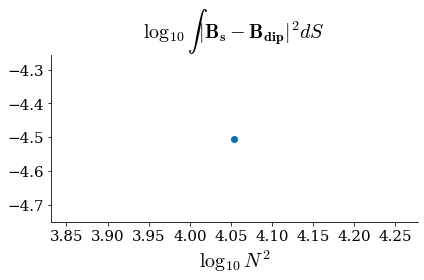

In [15]:
plot_xy(np.log10(b_chi), 
        np.log10(( sMv * 2 + 1 ) * ( sNv * 2 + 1 ) * 2), # grid to plot on
        ''r'$\log_{10} \int | \mathbf{B_s - B_{dip}} | ^2 dS$', # title for the figure
        ''r'$\log_{10} N^2 $', # title of x axis
       )

In [16]:
#plot_xy(np.log10(jnp.asarray(source_chi)), 
#        np.log10(( sMv * 2 + 1 ) * ( sNv * 2 + 1 ) * 2), # grid to plot on
#        ''r'$\log_{10} \Sigma d_i $', # title for the figure
#        ''r'$\log_{10} N^2 $', # title of x axis
#       )

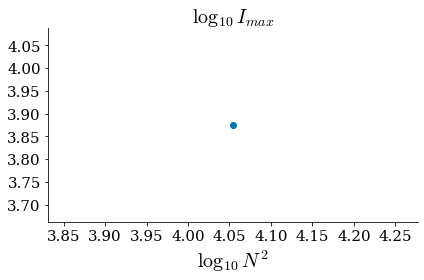

In [17]:
plot_xy(np.log10(jnp.asarray(max_I)), 
        np.log10(( sMv * 2 + 1 ) * ( sNv * 2 + 1 ) * 2), # grid to plot on
        ''r'$\log_{10} I_{max} $', # title for the figure
        ''r'$\log_{10} N^2 $', # title of x axis
       )

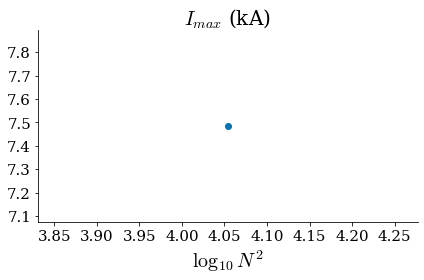

In [18]:
plot_xy(jnp.asarray(max_I)*1e-3, 
        np.log10(( sMv * 2 + 1 ) * ( sNv * 2 + 1 ) * 2), # grid to plot on
        ''r'$ I_{max} $ (kA)', # title for the figure
        ''r'$\log_{10} N^2 $', # title of x axis
        )